# 超参数和模型验证

监督机器学习模型的基本流程为，

1. 选择某一类模型


2. 设置模型的超参数


3. 用模型拟合训练数据


4. 使用模型预测新数据的标签


前两个部分（模型的选择和超参数的选择）可能是有效使用这些工具和技术的最重要部分。

> 为了做出明智的选择，我们需要一种方法来**验证**我们的模型和超参数是否适合数据。

虽然这听起来很简单，但是你必须避免一些陷阱才能有效地做到这一点。

## 模型验证

原则上，模型验证非常简单：

- 选择模型及其超参数后，通过将其应用于某些训练数据得到模型参数，并将预测值与已知标签进行比较来评估其有效性。

以下各节首先展示了一种简单的模型验证方法及其失败的原因，在探索使用子集和交叉验证以获得更强大功能之前模型评估。

### 错误的模型验证方式

让我们演示使用 iris 数据进行验证的简单方法，我们将从加载数据开始。

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

接下来，我们选择一个模型和超参数。在这里，我们将使用 `n_neighbors = 1` 的 k-近邻分类器。

这是一个非常简单直观的模型，它表示`未知点的标签与其最接近的训练点的标签相同`。

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

然后，我们训练模型，并使用它来预测已知数据的标签。

In [4]:
model.fit(X, y)
y_model = model.predict(X)

最后，我们计算正确标签预测正确的比例。

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

我们看到的准确性得分是 1.0，这表明我们的模型正确标记了 100％ 的点！
但这真的在衡量预期的准确性吗？我们是否真的得到了我们期望 100％ 正确的模型？

答案是否定的。

实际上，这种方法存在一个基本缺陷：

- 它在同一个数据集上训练和评估模型。

此外，最近邻模型是基于实例的估计器，它简单地存储训练数据，并通过将新数据与这些存储的点进行比较来预测标签：
- 在一般情况下，它将获得100％ 的准确性。

### 正确的模型验证：留出法

那该怎么办呢？可以使用称为 **holdout set** 的方法来更好地了解模型的性能：

- 将数据集分割成不同子集，模型训练使用其中部分数据子集，然后使用另外子集进行测试模型的性能。

可以使用 Scikit-Learn 中的 `train _test_ split` 来完成对数据集的拆分。

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 将数据集 5-5 开对分
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# 在其中一个子集上训练模型
model.fit(X1, y1)

# 在另一个子集上评估模型
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

我们看到一个更合理的结果：在此维持集上，最近邻居分类器的准确度约为 90％。

测试集类似于未知数据，因为该模型在训练时没有`看到过`它们。

### 通过交叉验证进行模型验证

使用留出法进行模型验证的一个缺点是：一部分数据对于模型训练并没有起到作用。

例如。在上述例子中，一半的数据集对模型的训练没有起到任何帮助！这不是最佳选择，并且可能导致问题 - 特别是在训练数据集很小的情况下。

解决此问题的一种方法是使用交叉验证（cross-validation）：

- 在子集上进行一系列交叉拟合，其中数据的每个子集既用作训练集又用作验证集。

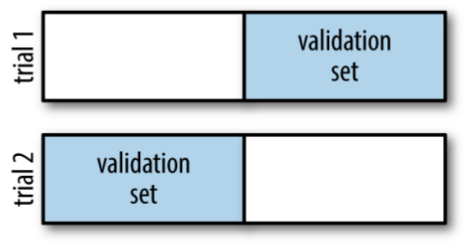

在这里，我们进行了两次验证试验，交替使用数据的每一半作为留出集。

上面例子中，我们使用上面的 5-5 开拆分子集，可以像下面这样实现它。

In [7]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)

accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

结果是两个准确性得分，我们可以将它们综合起来（例如，取平均值），以更好地衡量整体模型的性能。

这种特殊形式的交叉验证是**二折交叉验证**，也就是说，我们将数据分为两组，然后依次将它们用作验证组。

我们可以扩展这个想法，以便进行更多次训练，例如，以下是五折交叉验证的直观描述：

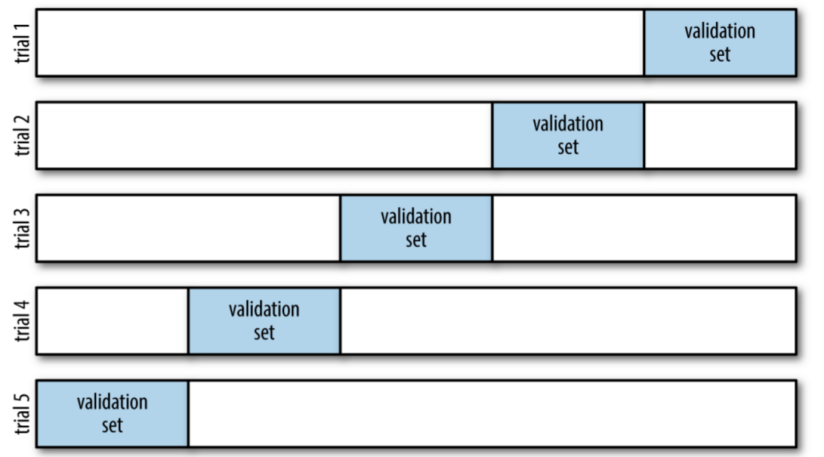

在这里，我们将数据分为五个组，然后依次使用它们来评估在其余 4/5 数据集上训练的模型。

手工完成这很繁琐，因此我们可以使用 Scikit-Learn 的 `cross_val_score` 来简洁地执行此操作。

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

在数据的不同子集上重复训练和验证，使我们对算法的性能有了更好的了解。

Scikit-Learn 实现了许多有用的交叉验证方案，这些方案在特定情况下很有用。

- 这些是通过 cross_validation 模块中的迭代器实现的。

例如，我们可能希望转到极端情况，在这种情况下，我们的折叠次数等于数据点的数目：

- 在每次试验中模型都在除去一个点之外的其他所有点上训练。

这种交叉验证类型称为 `leave-one-out` 交叉验证，可以按以下方式使用。

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=KFold(X.shape[0]))
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

因为我们有 150 个样本，所以留出一个交叉验证会得出 150 个试验的分数，该分数表示成功 1.0 或不成功 0.0 的预测。取平均值即可估算出错误率。

In [11]:
scores.mean()

0.96